In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from datetime import datetime
from py_vollib_vectorized import vectorized_implied_volatility as implied_vol
from datetime import datetime, timedelta
from matplotlib.dates import date2num, DateFormatter, DayLocator
from utils import process_asset_data, process_treasury_data, calculate_rolling_volatility
from pricing_models import HestonModel, OptionPricer

In [2]:
ticker = 'TSLA'

#Asset Data
asset_data = yf.download(ticker, '2010-01-01', datetime.today())
df = process_asset_data(ticker, asset_data)

df['rolling_vol'] = calculate_rolling_volatility(df['Close'], window=21)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
#Real Option Data
ticker = yf.Ticker(ticker)
strike_dates = ticker.options
strike_dates = sorted(strike_dates, key=lambda x: datetime.strptime(x, "%Y-%m-%d")) #Sort strike dates in ascending order

# Get option chain for specific expiration
exp_date = strike_dates[6]
df_calls, df_puts, _ = ticker.option_chain(exp_date)

In [4]:
# Fetch U.S. Treasury yield data from yfinance
tickers = ['^IRX', '^FVX', '^TNX', '^TYX']  # 3-month, 5-year, 10-year, and 30-year Treasury yield indices
treasury_data = yf.download(tickers, start=datetime.today() - timedelta(days=4), end=datetime.today())
df_treasury = process_treasury_data(treasury_data)

r = np.log(1+df_treasury['3M'].values[-1]/100) #Using 3 month treasury yield as proxy for risk free rate

[*********************100%***********************]  4 of 4 completed


In [5]:
Q = list(df['Change in asset returns'][22:]) # Vector of change in asset returns
V = list(df['rolling_vol'][22:]) # Vector of 21 day (monthly) rolling volatility

In [6]:
#Heston Parameter Estimation
# mle = MLEOptimizer(Q,V, r, n_guesses=20)
# results = mle.estimate_parameters_robust()

In [7]:
results = {'parameters': {'k': 0.5000000000000286,
  'theta': 0.012145851954587705,
  'sigma': 0.05065340912335228,
  'rho': -9.212526809174303e-08},
 'log_likelihood': 17253.44005854832,
 'convergence': True,
 'method': 'SLSQP',
 'initial_guess': [0.7097611362351037,
  0.042264392270772055,
  3.380841806454079,
  -0.7921994431283058],
 'message': 'Optimization terminated successfully'}

In [8]:
# results = {'parameters': {'k': 0.5000000004380865,
#   'theta': 0.0027922026202455616,
#   'sigma': 0.02488502340408709,
#   'rho': -5.61660291615257e-27},
#  'log_likelihood': 25061.307108168647,
#  'convergence': True,
#  'method': 'L-BFGS-B',
#  'initial_guess': [4.976890387641495,
#   0.1981660046638607,
#   0.24902874739548997,
#   -0.9064750001175033],
#  'message': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'}

In [9]:
# Model parameters
S0 = df['Close'].iloc[-1]    # Initial stock price
r = np.log(1+df_treasury['3M'].values[-1]/100) #results['parameters']['r']     # Risk-free rate
kappa = results['parameters']['k']   # Mean reversion rate
theta = results['parameters']['theta']   # Long-term average volatility
sigma = results['parameters']['sigma']    # Volatility of volatility
rho = results['parameters']['rho']     # Correlation coefficient
v0 = df['rolling_vol'].mean()    # Initial volatility

In [10]:
model = HestonModel(S0, r, kappa, theta, sigma, rho, v0)

S, V = model.heston_monte_carlo(T=1.0, N=252, mu=r) 

### AAPL Call Option Prices

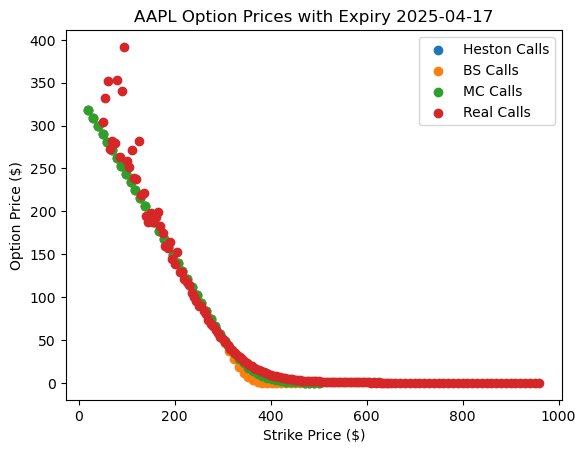

In [11]:
strikes = np.linspace(20, 500, 50)
today_date = datetime.today().strftime('%Y-%m-%d')
trading_days = len(pd.bdate_range(start=today_date, end=exp_date))

price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, S, V, option_type = 'call', pricer='heston')
heston_call_prices = price_model.price_options(strikes, trading_days/252)

mc_price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, S, V, option_type = 'call', pricer='monte_carlo')
monte_carlo_call_prices = price_model.price_options(strikes, trading_days)

price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, S, V, option_type = 'call', pricer='black_scholes')
black_scholes_call_prices = price_model.price_options(strikes, trading_days/252)

plt.scatter(strikes, heston_call_prices, label='Heston Calls')
plt.scatter(strikes, black_scholes_call_prices, label='BS Calls')
plt.scatter(strikes, monte_carlo_call_prices, label='MC Calls')
plt.scatter(df_calls['strike'], df_calls['lastPrice'], label='Real Calls')
plt.xlabel('Strike Price ($)')
plt.ylabel('Option Price ($)')
plt.title('AAPL Option Prices with Expiry {}'.format(exp_date))
plt.legend()

### Implied volatility 

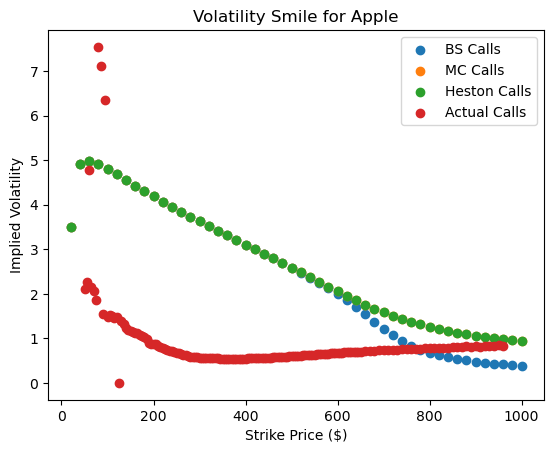

In [12]:
strikes = np.linspace(20, 1000, 50)

bs_call_ivs = implied_vol(black_scholes_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
mc_call_ivs = implied_vol(monte_carlo_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
heston_call_ivs = implied_vol(heston_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')

plt.scatter(strikes, bs_call_ivs, label='BS Calls')
plt.scatter(strikes, mc_call_ivs, label='MC Calls')
plt.scatter(strikes, heston_call_ivs, label='Heston Calls')
plt.scatter(df_calls['strike'], df_calls['impliedVolatility'], label='Actual Calls')

plt.title('Volatility Smile for Apple')
plt.xlabel('Strike Price ($)')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

### Volatility Surface for call options priced using Heston Monte Carlo

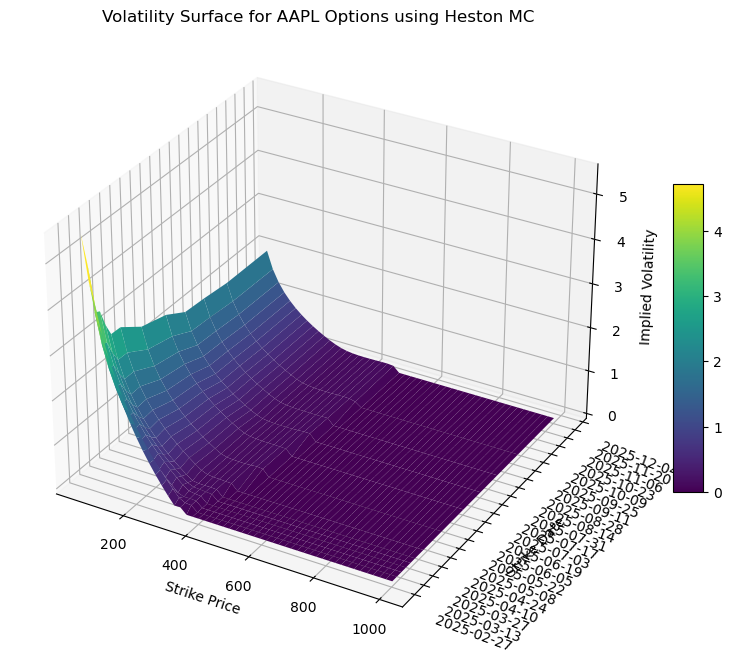

In [13]:
strike_dates = strike_dates[:13]
strikes = np.linspace(50, 1000, 50)

today_date = datetime.today().strftime('%Y-%m-%d')
mc_call_ivs_list = []

for strike in strike_dates:
    trading_days = len(pd.bdate_range(start=today_date, end=strike))
    MC_call_prices = mc_price_model.price_options(strikes, trading_days)
    mc_call_ivs = implied_vol(MC_call_prices,S0, strikes, trading_days/252, r, flag='c',q=0, return_as='numpy')
    mc_call_ivs_list.append(mc_call_ivs)

# Convert expiry dates to numerical format
strike_dates_num = date2num(strike_dates)

# Create a meshgrid for the expiry dates (y) and strikes (x)
Y, X = np.meshgrid(strike_dates_num, strikes, indexing='ij')
Z = np.array(mc_call_ivs_list)

# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Format the Y-axis as dates
ax.yaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_locator(DayLocator(interval=14))  # Adjust the interval for dates

# Rotate date labels for readability
plt.setp(ax.get_yticklabels(), rotation=30, ha='right')

# Add labels and title
ax.set_xlabel('Strike Price')
ax.set_ylabel('Strike Date')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface for AAPL Options using Heston MC')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.setp(ax.get_yticklabels(), rotation=-20, ha='left')

# Show the plot
plt.show()

### Volatility Surface with real option data from Yahoo Finance

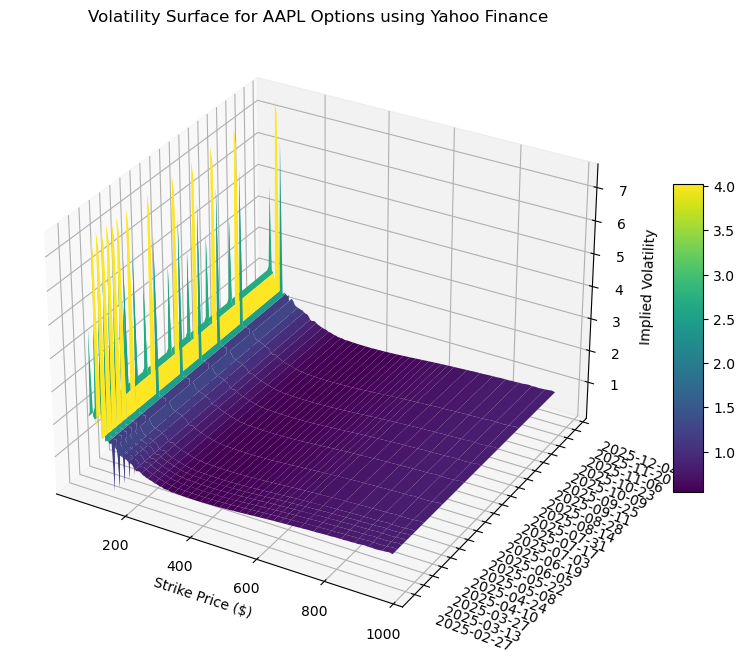

In [14]:

strike_dates = strike_dates[:13]
#strikes = np.linspace(50, 400, 50)

today_date = datetime.today().strftime('%Y-%m-%d')
yf_call_ivs_list = []
yf_strike_prices = []

for strike in strike_dates:
    df_calls, df_puts, _ = ticker.option_chain(exp_date)
    yf_strike_prices = df_calls['strike']
    yf_call_ivs_list.append(df_calls['impliedVolatility'])

# Convert expiry dates to numerical format
strike_dates_num = date2num(strike_dates)

# Create a meshgrid for the expiry dates (y) and strikes (x)
Y, X = np.meshgrid(strike_dates_num, yf_strike_prices, indexing='ij')
Z = np.array(yf_call_ivs_list)


# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# Format the Y-axis as dates
ax.yaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.yaxis.set_major_locator(DayLocator(interval=14))  # Adjust the interval for dates

# Rotate date labels for readability
plt.setp(ax.get_yticklabels(), rotation=30, ha='right')

# Add labels and title
ax.set_xlabel('Strike Price ($)')
#ax.set_ylabel('Strike Date')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface for AAPL Options using Yahoo Finance')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.setp(ax.get_yticklabels(), rotation=-20, ha='left')

# Show the plot
plt.show()
    

### Volatility Smiles

##### In this section, we check for volatility smiles of a call option with 1 year to expiration over a range of strikes from three option pricing techniques: 1. Heston Model, 2. Heston Model with Monte Carlo, 3. Black Scholes Model

In [15]:
T = 1.0
strikes = np.linspace(20, 600, 50)

sigma = results['parameters']['sigma']
theta = results['parameters']['theta']
v0 = df['rolling_vol'].mean()
kappa = results['parameters']['k']
rho = results['parameters']['rho']
r = np.log(1+df_treasury['3M'].values[-1]/100)

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [0, 2, 4, 6, 7]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


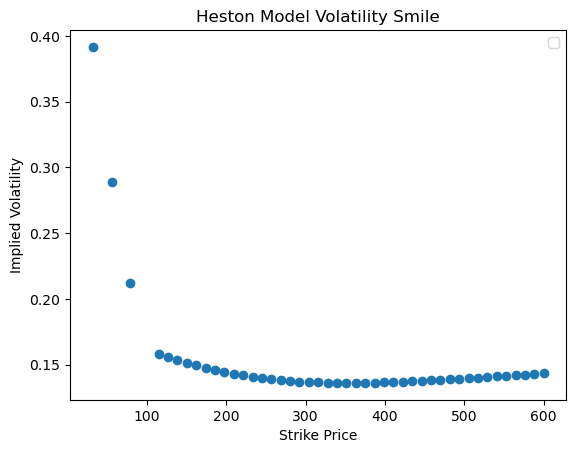

In [16]:
# Volatility smile for Heston model 

price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, S, V, option_type = 'call', pricer='heston')
heston_call_prices = price_model.price_options(strikes, T)

#puts = np.array([heston_option_price(S0, K, T, r, kappa, theta, sigma, rho, v0) for K in strikes])
call_ivs = implied_vol(heston_call_prices, S0, strikes, T, r, flag='c',q=0, return_as='numpy')
#puts_ivs = implied_vol(puts,S0, strikes, T, r, flag='p',q=0, return_as='numpy')

plt.scatter(strikes, call_ivs)
#plt.plot(strikes, puts_ivs, 'b-', label='Puts')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Heston Model Volatility Smile')
plt.legend()

c:\Users\uddin\anaconda3\envs\quant\Lib\site-packages\py_vollib_vectorized\implied_volatility.py:75: UserWarning: Found Below Intrinsic contracts at index [1, 7, 18]
  below_intrinsic, above_max_price = _check_below_and_above_intrinsic(K, F, flag, undiscounted_option_price, on_error)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


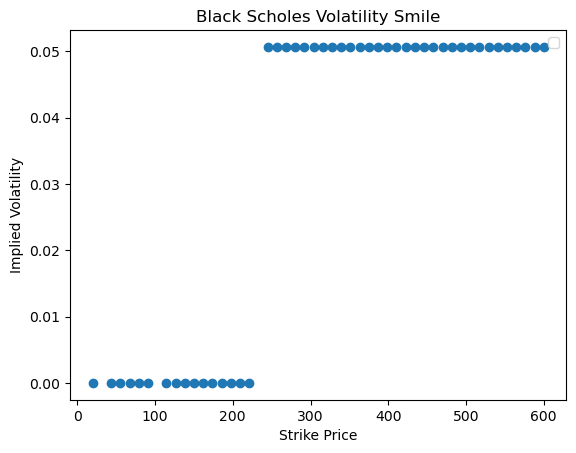

In [17]:
# volatility smile for Black-Scholes model


price_model = OptionPricer(S0, r, kappa, theta, sigma, rho, v0, S, V, option_type = 'call', pricer='black_scholes')
heston_call_prices = price_model.price_options(strikes, T)

#puts = np.array([heston_option_price(S0, K, T, r, kappa, theta, sigma, rho, v0) for K in strikes])
call_ivs = implied_vol(heston_call_prices, S0, strikes, T, r, flag='c',q=0, return_as='numpy')
#puts_ivs = implied_vol(puts,S0, strikes, T, r, flag='p',q=0, return_as='numpy')

plt.scatter(strikes, call_ivs)
#plt.plot(strikes, puts_ivs, 'b-', label='Puts')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Black Scholes Volatility Smile')
plt.legend()